In [2]:
import pandas as pd
import numpy as np
import Helper
import time

from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif

from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

np.random.seed(231)


import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def preprocess(X_train, X_test):
    """
    This method will preprocess the dataset based on X_train.
    The prepocess must follow the order:
    - Converting from categorical attributes to numeric attributes
    - Handle missing values
    - Standardising and/or Normalising the data
    :param X_train: Training set, must be Panda dataframe
    :param X_test: Test set, must be Panda dataframe
    :return: preprocessed X_train and X_test, must be Panda dataframe
    """
    # Record the categorical columns and numerical columns in X_train
    # Useful when you want to convert categorical columns only
    all_cols = X_train.columns
    cat_marks = X_train.dtypes == object
    categorical_cols = X_train.columns[cat_marks].tolist()
    numeric_columns = np.setdiff1d(X_train.columns, categorical_cols)

    # TO DO Your code goes here

    # Convert from categorical data to numerical data
    encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'error')
    X_train_encoded=X_train.copy()
    X_train_encoded = encoder.fit_transform(X_train_encoded[categorical_cols])
    X_test_encoded=X_test.copy()
    X_test_encoded = encoder.transform(X_test_encoded[categorical_cols])
   
   
    # Handle missing values
    imputer = KNNImputer()
    X_train_impute = imputer.fit_transform(X_train_encoded)
    X_test_impute = imputer.transform(X_test_encoded)
    

    # Normalising and/or Standardising dataset

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_impute)
    X_test_scaled = scaler.transform(X_test_impute)

    # Create DataFrame after scaling

    X_train1 = pd.DataFrame(X_train_scaled, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
    X_test1 = pd.DataFrame(X_test_scaled, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

    X_train = pd.concat([X_train1, X_train[numeric_columns]],axis=1)
    X_test = pd.concat([X_test1, X_test[numeric_columns]],axis =1) 

    global feature_names
    feature_names = X_train.columns.tolist()

    # Return the processed training and test set
    return X_train, X_test 


In [4]:
def feature_ranking(X_train, y_train, no_features=5):
    """
    Rank features based on the mutual information between each feature and the class label
    Step 1: calculate the mutual information between each feature and the class label
    Step 2: sort features based on their mutual information
    Step 3: get top "no_features" features
    :param X_train: numpy array
    :param y_train: numpy array
    :param no_features:
    :return: selected features
    """
    # TO DO: Your code goes here

    #X_train = X_train.values
    #y_train = y_train.values
    m_Info = mutual_info_classif(X_train, y_train)

    m_Info = np.abs(m_Info)
    sorted_features = np.argsort(m_Info)[::-1]
   
    selected_features = sorted_features[:no_features]

    top_feature_names = [feature_names[i] for i in selected_features]
    print("Top five features:", top_feature_names)

    return selected_features




In [5]:
def special_split(X, y, ratio=0.7):
    """
    This function splits the dataset into training and test sets so that the missing data is only in the training set.
    Make it easier to preprocess in this assignment
    :param X: feature matrix, must be Panda dataframe
    :param y: label vector, must be Panda dataframe
    :param ratio: testing ratio, default is 0.7
    :return: split training and test sets
    """
    n_i, n_f = X.shape
    n_train = int(0.7 * n_i)
    n_test = n_i - n_train

    null_rows = pd.isna(X).any(axis=1)
    null_rows = np.where(null_rows)[0]
    non_null_rows = np.setdiff1d(np.arange(0, n_i), null_rows)
    X_non_null, y_non_null = X.iloc[non_null_rows], y.iloc[non_null_rows]
    X_train, X_test, y_train, y_test = train_test_split(X_non_null, y_non_null, test_size=n_test, random_state=231)
    X_train, y_train = pd.concat([X_train, X.iloc[null_rows]]), pd.concat([y_train, y[null_rows]])
    train_per = np.random.permutation(X_train.shape[0])
    X_train, y_train = X_train.iloc[train_per], y_train.iloc[train_per]
    return X_train, X_test, y_train, y_test


In [6]:
def evaluation(clf, X_train, y_train, X_test, y_test):
    """
    Calculate the performance of a the classifier trained on the training set (X_train, y_train)
    and test the test set (X_test, y_test).
    :param clf: a classifier
    :param X_train: training feature matrix, must be numpy array
    :param y_train: training label vector, must be numpy array
    :param X_test: testing feature matrix, must be numpy array
    :param y_test: testing label vector, must be numpy array
    :return: classification accuracy
    """
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    acc = balanced_accuracy_score(y_true=y_test, y_pred=y_test_pred)
    return acc


In [7]:
def sequential_score(clf, X, y, S, n_folds=10):
    """
    Given the training set (X, y), we would like to evaluate the performance of the feature subset S
    1. Extract part of the training set containing only S
    1. Divide the dataset into n_folds
    2. for each fold
        - use that fold as the test set and all other folds as the training set
        - train clf on the training set and test it on the test set
    3. calculate and return the average performance across n_folds
    :param clf: a classification algorithm
    :param X: feature matrix, must be numpy array
    :param y: label vector, must be numpy array
    :param S: subset of selected features, must be numpy array
    :param n_folds: number of folds, default is 10
    :return:
    """
    split = KFold(n_splits=n_folds)
    X_sel = X[:, S]
    # TO DO: Your code goes here
    scores = []
    for train_index, test_index in split.split(X_sel):
        X_train, X_test = X_sel[train_index], X_sel[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores.append(score)
    return np.mean(scores)

def sequential_feature_selection(X, y, no_features=5):
    """
    1. Initialise subset of selected features to an empty set
    2. Initialise subset of remaining features to the original set of features
    3. Repeat the following steps until a predefined number of features (no_features) is selected:
        - For each remaining feature
            + form a new feature subset consisting of the remaining feature and the subset of selected features
            + extract a feature matrix containing only the new feature subset
            + use the newly extracted feature matrix in using sequential_score() to get the learning performance (score)
            + record the best remaining feature which results in the highest score
        - Add the best remaining feature to the subset of selected features
        - Remove the best remaining feature from the subset of remaining features
    4. Return the subset of selected features
    :param X: training feature matrix X, must be numpy array
    :param y: training label vector y, must be numpy array
    :param no_features: number of selected feature
    :return: subset of selected features
    """
    # classifier to be used in sequential_score()
    clf = KNN(n_neighbors=3)
    # initialise the subset of selected features and the subset of remaining features
    selected_features = np.array([], dtype=int)
    remaining_features = np.arange(0, X.shape[1])

    # TO DO: Your code to do sequential feature selection
    for i in range(no_features):
        best_score = -1
        best_feature = None
        for feature in remaining_features:
            temp_features = np.append(selected_features, feature)
            score = sequential_score(clf, X, y, temp_features)
            if score > best_score:
                best_score = score
                best_feature = feature
        selected_features = np.append(selected_features, best_feature)
        remaining_features = np.setdiff1d(remaining_features, best_feature)

    top_feature_names = [feature_names[i] for i in selected_features]
    print("5 features selected by SFFS::", top_feature_names)

    return selected_features


In [8]:
if __name__ == '__main__':
    # load data to data frame
    df = pd.read_csv('Data.csv')
    X, y = df.drop('Class', axis=1), df['Class']

    # splitting dataset into training and test set, only training set has missing values
    X_train, X_test, y_train, y_test = Helper.special_split(X, y, ratio=0.7)

    # Preprocess the data
    X_train, X_test = preprocess(X_train, X_test)

    # Converting from data frame to numpy for the selection tasks
    X_train, X_test = X_train.values, X_test.values
    y_train, y_test = y_train.values, y_test.values
    clf = KNN(n_neighbors=3)

    # performance of using all features
    print("****************All features********************\n")
    all_acc = Helper.evaluation(clf, X_train, y_train, X_test, y_test)
    print('Accuracy of using all features: %.2f\n' % (all_acc * 100))

     # Feature ranking
    start = time.time()
    print("**Feature ranking**")
    top_features = feature_ranking(X_train, y_train, no_features=5)
    rank_acc = Helper.evaluation(clf, X_train[:, top_features], y_train, X_test[:, top_features], y_test)
    print('Top 5 ranking features: %s ' % ('[' + ', '.join([str(val) for val in top_features]) + ']'))
    print('Accuracy of using top five features: %.2f' % (rank_acc * 100))
    end = time.time()
    print('Computational time for feature ranking: %.10f seconds\n' % ((end - start)))
    # Sequential Feature selection
    start = time.time()
    print("**Sequential Forward Feature Selection**")
    sel_features = sequential_feature_selection(X_train, y_train, no_features=5)
    sffs_acc = Helper.evaluation(clf, X_train[:, sel_features], y_train, X_test[:, sel_features], y_test)
    print('5 features selected by SFFS: %s' % ('[' + ', '.join([str(val) for val in sel_features]) + ']'))
    print('Accuracy of SFFS: %.2f' % (sffs_acc * 100))
    end = time.time()
    print('Computational time for SFFS: %.10f seconds' % ((end - start)))

****************All features********************

Accuracy of using all features: 53.68

**Feature ranking**
Top five features: ['Att1_A14', 'Att2', 'Att3_A30', 'Att7_A74', 'Att11']
Top 5 ranking features: [3, 59, 5, 28, 55] 
Accuracy of using top five features: 60.30
Computational time for feature ranking: 0.3002161980 seconds

**Sequential Forward Feature Selection**
5 features selected by SFFS:: ['Att3_A31', 'Att4_A44', 'Att7_A72', 'Att1_A12', 'Att3_A33']
5 features selected by SFFS: [6, 15, 26, 1, 8]
Accuracy of SFFS: 52.30
Computational time for SFFS: 19.8757586479 seconds


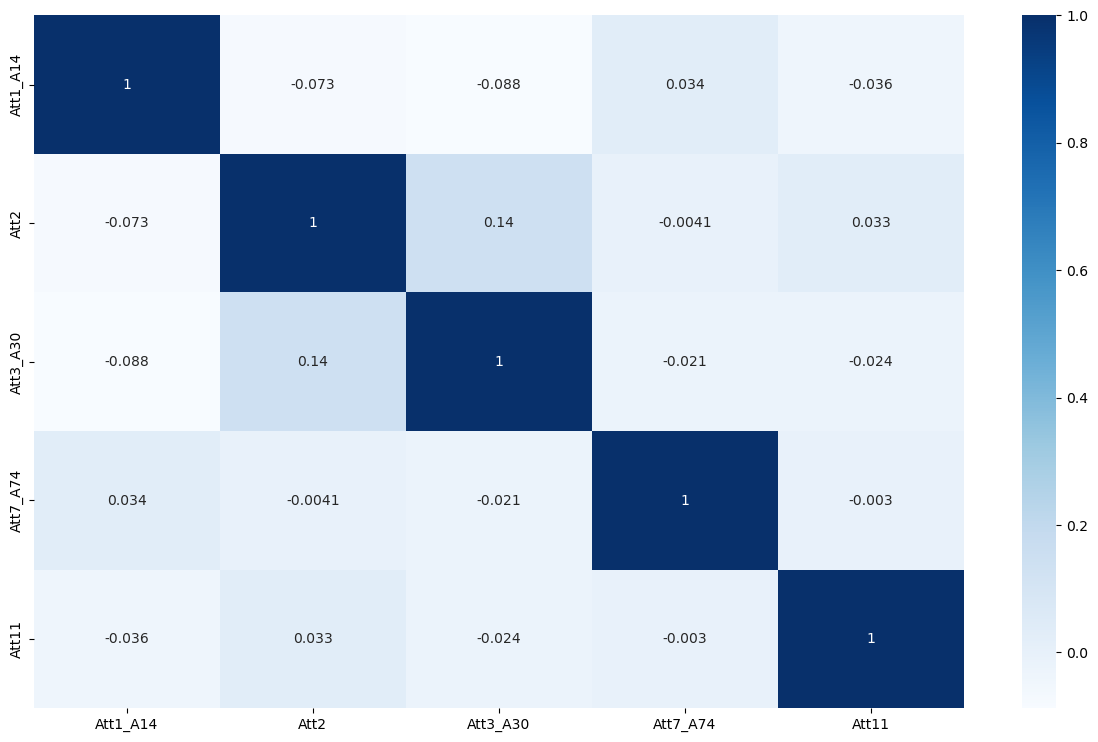

In [9]:
X_t = X_train[:,top_features]



df2 = pd.DataFrame(X_t, columns=[feature_names[i] for i in top_features])
X_t

fig = plt.figure(figsize = (15,9))
sns.heatmap(df2.corr(), cmap='Blues', annot = True);

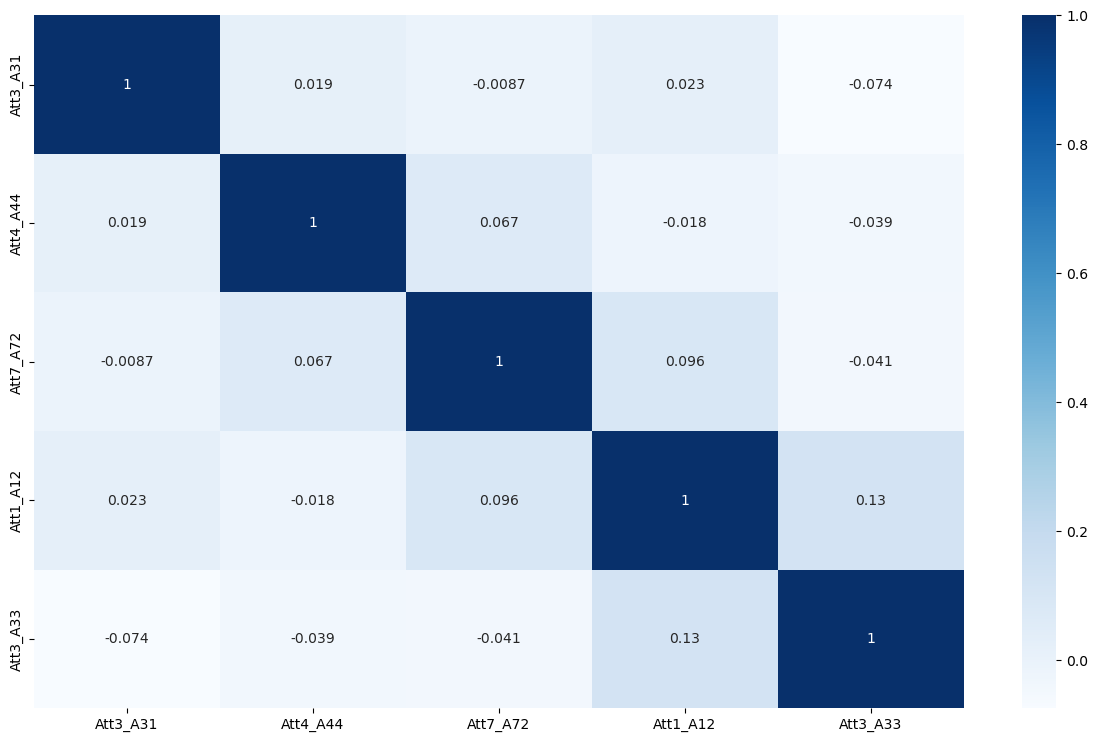

In [10]:
X_t = X_train[:,sel_features]



df2 = pd.DataFrame(X_t, columns=[feature_names[i] for i in sel_features])
X_t

fig = plt.figure(figsize = (15,9))
sns.heatmap(df2.corr(), cmap='Blues', annot = True);